# Task 2 - Data Exploration, Analysis, and Preprocessing 

This notebook covers data quality, integration, comprehensive exploration, and preparing the data for the modeling tasks.

## 2.1 Setup and Data Loading

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np

# Load the two primary datasets (Power Generation and Sensor Data for each plant)
plant1_gen = pd.read_csv('../data/raw/Plant_1_Generation_Data.csv')
plant1_weather = pd.read_csv('../data/raw/Plant_1_Weather_Sensor_Data.csv')
plant2_gen = pd.read_csv('../data/raw/Plant_2_Generation_Data.csv')
plant2_weather = pd.read_csv('../data/raw/Plant_2_Weather_Sensor_Data.csv')

## 2.2 Data Quality and Integration

### 2.2.1 Data Quality Assessment

#### A. General checks

##### Data Duplicates

In [51]:
# Check for row duplicates in each dataset
print("Plant 1 Generation duplicates:", plant1_gen.duplicated().sum(), f"({round(plant1_gen.duplicated().sum()/len(plant1_gen)*100, 2)}%)")
print("Plant 2 Generation duplicates:", plant2_gen.duplicated().sum(), f"({round(plant2_gen.duplicated().sum()/len(plant2_gen)*100, 2)}%)")
print("Plant 1 Weather duplicates:", plant1_weather.duplicated().sum(), f"({round(plant1_weather.duplicated().sum()/len(plant1_weather)*100, 2)}%)")
print("Plant 2 Weather duplicates:", plant2_weather.duplicated().sum(), f"({round(plant2_weather.duplicated().sum()/len(plant2_weather)*100, 2)}%)")

Plant 1 Generation duplicates: 911114 (89.22%)
Plant 2 Generation duplicates: 1291888 (90.9%)
Plant 1 Weather duplicates: 0 (0.0%)
Plant 2 Weather duplicates: 0 (0.0%)


In [52]:
# Constants for 34 Days @ 15-min intervals
DAYS = 34
READINGS_PER_DAY = 24 * 4 # 96
EXPECTED_PER_SENSOR = DAYS * READINGS_PER_DAY

def analyse_dataset(df, plant_label="Plant 1", days=DAYS, readings_per_day=READINGS_PER_DAY):
    """
    Analyzes the dataset to compute expected vs actual readings per sensor/inverter.
    """
    inverter_count = df['SOURCE_KEY'].nunique()
    expected_readings = days * readings_per_day * inverter_count
    actual_readings = len(df)
    diff = actual_readings - expected_readings

    print(f"\n--- {plant_label} Generation Data ---")
    print(f"1. Unique Inverters identified: {inverter_count}")
    print(f"2. Expected Readings (Target):  {expected_readings:,}")
    print(f"   (Calculation: {days} days * {readings_per_day} readings * {inverter_count} inverters)")
    print(f"3. Actual Readings (Raw):       {actual_readings:,}")
    print(f"4. Conclusion:                  {diff:+,} Rows")


p1_gen_stats = analyse_dataset(plant1_gen, "Plant 1")
p2_gen_stats = analyse_dataset(plant2_gen, "Plant 2")
p1_weather_stats = analyse_dataset(plant1_weather, "Plant 1 Weather")
p2_weather_stats = analyse_dataset(plant2_weather, "Plant 2 Weather")


--- Plant 1 Generation Data ---
1. Unique Inverters identified: 22
2. Expected Readings (Target):  71,808
   (Calculation: 34 days * 96 readings * 22 inverters)
3. Actual Readings (Raw):       1,021,186
4. Conclusion:                  +949,378 Rows

--- Plant 2 Generation Data ---
1. Unique Inverters identified: 22
2. Expected Readings (Target):  71,808
   (Calculation: 34 days * 96 readings * 22 inverters)
3. Actual Readings (Raw):       1,421,196
4. Conclusion:                  +1,349,388 Rows

--- Plant 1 Weather Generation Data ---
1. Unique Inverters identified: 1
2. Expected Readings (Target):  3,264
   (Calculation: 34 days * 96 readings * 1 inverters)
3. Actual Readings (Raw):       3,182
4. Conclusion:                  -82 Rows

--- Plant 2 Weather Generation Data ---
1. Unique Inverters identified: 1
2. Expected Readings (Target):  3,264
   (Calculation: 34 days * 96 readings * 1 inverters)
3. Actual Readings (Raw):       3,259
4. Conclusion:                  -5 Rows


In [53]:
# # Slice and do a visual inspection of the data to understand duplications

# # Define "Primary Keys" to make a row unique.
# key_columns = ['DATE_TIME', 'DC_POWER', 'SOURCE_KEY']

# # Find rows with duplicate Keys AND NOT duplicate Data
# has_duplicate_keys = plant1_gen.duplicated(subset=key_columns, keep=False)
# is_exact_duplicate = plant1_gen.duplicated(keep=False)

# # We only want rows where keys match, but data differs
# conflict_mask = has_duplicate_keys & ~is_exact_duplicate

# # Grab 1 random row to act as search parameter
# target_row = plant1_gen[conflict_mask].sample(1)

# # Retrieve the target row and its conflicts
# result = plant1_gen.merge(target_row[key_columns], on=key_columns)

# # Display result
# print(result)

**Conclusion:**
- When slicing data, we observe exact time stamps with all variables equal except for "operating_condition". Understanding this in detail and cleaning accordingly will be critical for the "Classification of Operating Conditions" task.

In [54]:
## Check data types
def get_types_report(df):
    """Generate a report of pandas dtypes and unique Python types for each column in the DataFrame."""
    types = {}
    for col in df.columns:
        # Get unique python types in the column (useful for spotting mixed types)
        py_types = df[col].map(lambda x: type(x).__name__).unique().tolist()
        types[col] = py_types

    result_df = pd.DataFrame({
        'column': list(types.keys()),
        'pandas_dtype': [df[col].dtype for col in types.keys()],
        'python_types': [types[col] for col in types.keys()]
    })
    return result_df

# Get unique Python types and pandas dtypes for the four datasets
print("Plant 1 Generation - Data Types Report:")
print(get_types_report(plant1_gen), "\n")

print("Plant 1 Weather - Data Types Report:")
print(get_types_report(plant1_weather), "\n")

print("Plant 2 Generation - Data Types Report:")
print(get_types_report(plant2_gen), "\n")

print("Plant 2 Weather - Data Types Report:")
print(get_types_report(plant2_weather))

Plant 1 Generation - Data Types Report:
                column pandas_dtype  python_types
0            DATE_TIME       object         [str]
1             PLANT_ID        int64         [int]
2           SOURCE_KEY       object         [str]
3             DC_POWER      float64       [float]
4             AC_POWER      float64       [float]
5          DAILY_YIELD      float64       [float]
6          TOTAL_YIELD      float64       [float]
7                  day        int64         [int]
8  Operating_Condition       object  [str, float] 

Plant 1 Weather - Data Types Report:
                column pandas_dtype python_types
0            DATE_TIME       object        [str]
1             PLANT_ID        int64        [int]
2           SOURCE_KEY       object        [str]
3  AMBIENT_TEMPERATURE      float64      [float]
4   MODULE_TEMPERATURE      float64      [float]
5          IRRADIATION      float64      [float] 

Plant 2 Generation - Data Types Report:
                column pandas_dtype 

**Conclusion:**
- Mixed formats: In "Plant 1 - Generation data" the variable "Operating_Condition" mariable exhibits mixed data types, strings and float. This means there are probably missing values in this column (NaN)

- Integers for categorical information: Variable Plant_ID is currently encoded as an integer across, is shown as an integer. However, it serves as a unique categorical identifier rather than a quantitative metric. This distinction must be explicitly noted during modeling to ensure algorithms do not misinterpret the ID as having numerical magnitude or order

#### B. Missing Values

In [55]:
## Check for missing values in the four data sets

def get_missing_data_report(df):
    """Generate a report of missing data percentages for each column in the DataFrame."""
    missing_data_report = pd.DataFrame({
        'Columns': df.columns,
        'Missing Values': df.isna().sum().values,
        'Percentage Missing': ((df.isna().sum().values / len(df)) * 100).round(2)
    })
    return missing_data_report

# Generate and print missing data report for the datasets
print("Power Generation 1 - Missing Values Report:")
print(get_missing_data_report(plant1_gen),"\n")
print("Weather Sensor 1 - Missing Values Report:")
print(get_missing_data_report(plant1_weather))
print("Power Generation 2 - Missing Values Report:")
print(get_missing_data_report(plant2_gen),"\n")
print("Weather Sensor 2- Missing Values Report:")
print(get_missing_data_report(plant2_weather))

Power Generation 1 - Missing Values Report:
               Columns  Missing Values  Percentage Missing
0            DATE_TIME               0                0.00
1             PLANT_ID               0                0.00
2           SOURCE_KEY               0                0.00
3             DC_POWER               0                0.00
4             AC_POWER               0                0.00
5          DAILY_YIELD               0                0.00
6          TOTAL_YIELD               0                0.00
7                  day               0                0.00
8  Operating_Condition           23098                2.26 

Weather Sensor 1 - Missing Values Report:
               Columns  Missing Values  Percentage Missing
0            DATE_TIME               0                 0.0
1             PLANT_ID               0                 0.0
2           SOURCE_KEY               0                 0.0
3  AMBIENT_TEMPERATURE               0                 0.0
4   MODULE_TEMPERATURE     

In [56]:
## Check for missing data ranges (rows) in the four data sets
# -------------------------------------------------------
# Generate a report
# -------------------------------------------------------
def get_time_gap_report(df):
    """
    Generate a report of missing time intervals in the DataFrame.
    Assumes 'DATE_TIME' column exists.
    """
    # Ensure datetime and sort
    df = df.copy()
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
    df = df.sort_values('DATE_TIME')
    
    # Create the expected grid for the intervals (perfect 15 min intervals)
    start = df['DATE_TIME'].min()
    end = df['DATE_TIME'].max()
    expected_range = pd.date_range(start=start, end=end, freq='15min')
    
    # Calculate statistics
    expected_count = len(expected_range)
    actual_count = df['DATE_TIME'].nunique()
    missing_count = expected_count - actual_count
    pct_missing = (missing_count / expected_count) * 100
    
    # Create Report DataFrame
    report = pd.DataFrame({
        'Metric': ['Start Time', 'End Time', 'Expected Intervals', 'Actual Intervals', 'Missing Intervals', '% Missing'],
        'Value': [start, end, expected_count, actual_count, missing_count, round(pct_missing, 2)]
    })
    return report

# Generate and print time gap reports
print("Power Generation 1 - Time Gap Report:")
print(get_time_gap_report(plant1_gen),"\n")

print("Weather Sensor 1 - Time Gap Report:")
print(get_time_gap_report(plant1_weather),"\n")

print("Power Generation 2 - Time Gap Report:")
print(get_time_gap_report(plant2_gen),"\n")

print("Weather Sensor 2 - Time Gap Report:")
print(get_time_gap_report(plant2_weather))

Power Generation 1 - Time Gap Report:
               Metric                Value
0          Start Time  2020-01-06 00:00:00
1            End Time  2020-12-06 23:45:00
2  Expected Intervals                32256
3    Actual Intervals                 3158
4   Missing Intervals                29098
5           % Missing                90.21 

Weather Sensor 1 - Time Gap Report:
               Metric                Value
0          Start Time  2020-05-15 00:00:00
1            End Time  2020-06-17 23:45:00
2  Expected Intervals                 3264
3    Actual Intervals                 3182
4   Missing Intervals                   82
5           % Missing                 2.51 

Power Generation 2 - Time Gap Report:
               Metric                Value
0          Start Time  2020-05-15 00:00:00
1            End Time  2020-06-17 23:45:00
2  Expected Intervals                 3264
3    Actual Intervals                 3259
4   Missing Intervals                    5
5           % Missing   

**Conclusion:** 

Missing values (NaN):
- Plant 1: Generation data exhibits missing values. There are about 2.3% missing values in the Operating_Condition column of the data set. On the contrary, weather data shows 0 missing values (empty cells)
- Plant 2: There are no missing values in the generation or weather data.

Missing temporal datetimes (entire rows):
- Plant 1: Is the only one with a time range different from the other datasets. We suspect the date format is not consistent and it is also the reason why the missing value count is high (around 90%) thus needs to be fixed.
- Plant 2: The datetime coverage is nearly perfect, it only misses 5 intervals (0.15%) of information.

#### C. Inconsistencies & Anomalies

##### Date Format Fixes

In [57]:
# Ensure all time columns are datetime objects
plant1_weather['DATE_TIME'] = pd.to_datetime(plant1_weather['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
plant2_weather['DATE_TIME'] = pd.to_datetime(plant2_weather['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
plant2_gen['DATE_TIME'] = pd.to_datetime(plant2_gen['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

In [58]:
# The timerange of the data is known to be within May 15 and June 17
print("Data timerange:", plant1_weather['DATE_TIME'].min(), "to", plant1_weather['DATE_TIME'].max())

Data timerange: 2020-05-15 00:00:00 to 2020-06-17 23:45:00


In [59]:
# Resolve DATE_TIME format ambiguity in Plant 1 Generation Data
# Extract month and day parts from DATE_TIME
plant1_gen = plant1_gen.join(plant1_gen['DATE_TIME'].str.extract(r'-(\d{2})-(\d{2}) ')).rename(columns={0: 'mid', 1: 'right'})

# Determine date format based on extracted parts knowing that the timerange of the data is known to be within May 15 and June 17
plant1_gen['date_format'] = ''
plant1_gen.loc[(plant1_gen['mid']=='05') & (plant1_gen['right']=='06'), "date_format"] = 'dd-mm'
plant1_gen.loc[(plant1_gen['mid']=='06') & (plant1_gen['right']=='05'), "date_format"] = 'mm-dd'
plant1_gen.loc[((plant1_gen['mid']=='05') | (plant1_gen['mid']=='06')) & (plant1_gen['date_format'] == ''), "date_format"] = 'mm-dd'
plant1_gen.loc[((plant1_gen['right']=='05') | (plant1_gen['right']=='06')) & (plant1_gen['date_format'] == ''), "date_format"] = 'dd-mm'

# Convert DATE_TIME to datetime using the determined format
mask_ddmm = plant1_gen['date_format'] == 'dd-mm'
mask_mmdd = plant1_gen['date_format'] == 'mm-dd'
plant1_gen.loc[mask_ddmm,"DATE_TIME"] = pd.to_datetime(plant1_gen.loc[mask_ddmm,"DATE_TIME"], format='%Y-%d-%m %H:%M:%S')
plant1_gen.loc[mask_mmdd,"DATE_TIME"] = pd.to_datetime(plant1_gen.loc[mask_mmdd,"DATE_TIME"], format='%Y-%m-%d %H:%M:%S')
plant1_gen['DATE_TIME'] = pd.to_datetime(plant1_gen['DATE_TIME']) # Final conversion to datetime
plant1_gen = plant1_gen.drop(columns=['mid', 'right', 'date_format'])

In [60]:
# Generate and print the time gap report again for Plant 1 Generation Data (after fixing DATE_TIME format)
print("Power Generation 1 - Time Gap Report:")
print(get_time_gap_report(plant1_gen),"\n")

Power Generation 1 - Time Gap Report:
               Metric                Value
0          Start Time  2020-05-15 00:00:00
1            End Time  2020-06-17 23:45:00
2  Expected Intervals                 3264
3    Actual Intervals                 3158
4   Missing Intervals                  106
5           % Missing                 3.25 



With the right date format correction, plant generation 1 presents a 3.25% of missing date intervals (instead of 90%+ before the fix).

##### Power Format Fixes

In [61]:
print("Power Generation Plant 1\n", plant1_gen[['DC_POWER','AC_POWER']].describe(),"\n")
print("Power Generation Plant 2\n", plant2_gen[['DC_POWER','AC_POWER']].describe())

Power Generation Plant 1
            DC_POWER      AC_POWER
count  1.021186e+06  1.021186e+06
mean   3.214259e+03  3.143240e+02
std    4.083181e+03  3.989361e+02
min    0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00
50%    5.161250e+02  4.992500e+01
75%    6.504625e+03  6.371375e+02
max    1.447112e+04  1.410950e+03 

Power Generation Plant 2
            DC_POWER      AC_POWER
count  1.421196e+06  1.421196e+06
mean   2.446906e+02  2.393180e+02
std    3.675888e+02  3.592099e+02
min    0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00
50%    0.000000e+00  0.000000e+00
75%    4.424643e+02  4.340333e+02
max    1.420933e+03  1.385420e+03


From the observation of the DC and AC power generation descriptive statistics, we notice that Plant 1's DC power values are an order of magnitude higher than Plant 2's. To fix this error in the data, we scale down Plant 1's DC power values by a factor of 10 to ensure consistency across both plants.

In [62]:
# Fix DC_POWER scale issue in Plant 1 Generation Data
plant1_gen['DC_POWER'] = plant1_gen['DC_POWER'] / 10

In [63]:
# Reprint descriptive statistics after fixing DC_POWER scale issue
print("Power Generation Plant 1\n", plant1_gen[['DC_POWER','AC_POWER']].describe(),"\n")
print("Power Generation Plant 2\n", plant2_gen[['DC_POWER','AC_POWER']].describe())

Power Generation Plant 1
            DC_POWER      AC_POWER
count  1.021186e+06  1.021186e+06
mean   3.214259e+02  3.143240e+02
std    4.083181e+02  3.989361e+02
min    0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00
50%    5.161250e+01  4.992500e+01
75%    6.504625e+02  6.371375e+02
max    1.447112e+03  1.410950e+03 

Power Generation Plant 2
            DC_POWER      AC_POWER
count  1.421196e+06  1.421196e+06
mean   2.446906e+02  2.393180e+02
std    3.675888e+02  3.592099e+02
min    0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00
50%    0.000000e+00  0.000000e+00
75%    4.424643e+02  4.340333e+02
max    1.420933e+03  1.385420e+03


Now the power values look consistent between both plants.

##### Further Checks

In [64]:
## Inconsistencies are checked for different situations for all data sets
# Grouping for iteration
gen_data = [("Plant 1", plant1_gen), ("Plant 2", plant2_gen)]
weather_data = [("Plant 1", plant1_weather), ("Plant 2", plant2_weather)]


## Part A: Generation data
print("\n--- POWER GENERATION CHECKS ---")

# CHECK 1: Efficiency violation 
# Impossible for AC Output > DC Input (inverter efficiency can't be > 100%)

print("\n[Gen Check 1] Efficiency violation (AC > DC)")
for name, df in gen_data:
    # We allow a tiny buffer (0.1 kW) for sensor timing mismatch
    errors = df[df['AC_POWER'] > df['DC_POWER'] + 0.1]
    print(f"  {name}: {len(errors)} rows failed.")

# CHECK 2: Negative power
# Solar panels cannot consume power (cannot be negative)
print("\n[Gen Check 2] Negative power (AC or DC < 0)")
for name, df in gen_data:
    errors = df[(df['AC_POWER'] < 0) | (df['DC_POWER'] < 0)]
    print(f"  {name}: {len(errors)} rows failed.")


## Part B: Weather data

print("\n--- WEATHER CHECKS ---")

# CHECK 1: No irradiance at night
# Irradiance > 0 when it is dark (10 PM - 4 AM short range assuming its summer)
print("\n[Weather Check 1] Night irradiance (Irradiation > 0 at Night)")
for name, df in weather_data:
    hour = df['DATE_TIME'].dt.hour
    night_mask = (hour >= 22) | (hour < 4)
    errors = df[night_mask & (df['IRRADIATION'] > 0)]
    print(f"  {name}: {len(errors)} rows failed.")

# CHECK 2: Panel being hot without irradiance at night
# No Sun (0 Irr) but Module is significantly hotter than Ambient
print("\n[Weather Check 2] Hot panel at night (Mod Temp > Amb Temp + 5°C w/ no Sun)")
for name, df in weather_data:
    # If Irradiance is 0, Module shouldn't be hot compared to air
    errors = df[(df['IRRADIATION'] == 0) & 
                (df['MODULE_TEMPERATURE'] > df['AMBIENT_TEMPERATURE'] + 5.0)]
    print(f"  {name}: {len(errors)} rows failed.")

# CHECK 3: Broken sensors
# Ambient Temp stays exactly the same for 4 consecutive readings (1 hour). Testing for a extreme case.
print("\n[Weather Check 3] Broken sensors (Ambient Temp frozen for 1hr)")
for name, df in weather_data:
    df_sorted = df.sort_values(by='DATE_TIME') 
    
    # True if current value equals previous value
    is_frozen = df_sorted['AMBIENT_TEMPERATURE'].diff() == 0
    
    # Rolling sum: if 4 consecutive rows are "True", we have a 1-hour freeze
    frozen_blocks = is_frozen.rolling(4).sum() == 4
    print(f"  {name}: {frozen_blocks.sum()} frozen sequences found.")


--- POWER GENERATION CHECKS ---

[Gen Check 1] Efficiency violation (AC > DC)
  Plant 1: 396 rows failed.
  Plant 2: 396 rows failed.

[Gen Check 2] Negative power (AC or DC < 0)
  Plant 1: 0 rows failed.
  Plant 2: 0 rows failed.

--- WEATHER CHECKS ---

[Weather Check 1] Night irradiance (Irradiation > 0 at Night)
  Plant 1: 0 rows failed.
  Plant 2: 24 rows failed.

[Weather Check 2] Hot panel at night (Mod Temp > Amb Temp + 5°C w/ no Sun)
  Plant 1: 0 rows failed.
  Plant 2: 0 rows failed.

[Weather Check 3] Broken sensors (Ambient Temp frozen for 1hr)
  Plant 1: 0 frozen sequences found.
  Plant 2: 0 frozen sequences found.


**Conclusion:** 

Generation data
- Plant 1: There are 396 instances (~0.6%) of efficiency violations (system reports that AC output is higher than DC, which is physically imposible).
- Plant 2: There are 396 instances (~0.6%) of efficiency violations (system reports that AC output is higher than DC, which is physically imposible).

Weather data
- Plant 1: Passed all consistency checks
- Plant 2: 24 instances (~0.7%) of "Night Sun" (Irradiance > 0 at night) This culd be due to the sunrise/sunset exact timings or callibration

### 2.2.2 Data Handling

In [65]:
# SHOULD WE DROP DUPLICATES??? ask Panagiotis Angeloudis
def recalculate_yields(df, drop_dup=True):
    df = df.copy()
    if drop_dup:
        df.drop_duplicates(subset=['DATE_TIME', 'SOURCE_KEY'], inplace=True)
    df.sort_values(by=['DATE_TIME', 'SOURCE_KEY'], inplace=True)

    # day/month for per-day grouping
    df['day'] = df['DATE_TIME'].dt.day
    df['month'] = df['DATE_TIME'].dt.month

    # DAILY_YIELD: cumulative AC_POWER per SOURCE_KEY per day
    df['DAILY_YIELD'] = df.groupby(['SOURCE_KEY', 'month', 'day'])['AC_POWER'].cumsum()

    # ensure TOTAL_YIELD column exists for the earliest-yield lookup
    if 'TOTAL_YIELD' not in df.columns:
        df['TOTAL_YIELD'] = np.nan

    # get earliest DATE_TIME per SOURCE_KEY and corresponding TOTAL_YIELD
    min_dates = df.groupby('SOURCE_KEY', as_index=False)['DATE_TIME'].min()
    first_yield = (min_dates
                   .merge(df[['SOURCE_KEY', 'DATE_TIME', 'TOTAL_YIELD']],
                          on=['SOURCE_KEY', 'DATE_TIME'],
                          how='left')
                   [['SOURCE_KEY', 'DATE_TIME', 'TOTAL_YIELD']]
                   .drop_duplicates('SOURCE_KEY')
                   .rename(columns={'DATE_TIME': 'FIRST_DATE_TIME', 'TOTAL_YIELD': 'FIRST_TOTAL_YIELD'}))

    # merge FIRST_TOTAL_YIELD and fill missing with 0
    df = df.merge(first_yield[['SOURCE_KEY', 'FIRST_TOTAL_YIELD']], on='SOURCE_KEY', how='left')
    df['FIRST_TOTAL_YIELD'] = df['FIRST_TOTAL_YIELD'].fillna(0.0)

    # recompute TOTAL_YIELD
    df['TOTAL_YIELD'] = df['DAILY_YIELD'] + df['FIRST_TOTAL_YIELD']

    # cleanup helper columns
    df.drop(columns=['day', 'month', 'FIRST_TOTAL_YIELD'], inplace=True)
    return df

# Apply to both plants and assign back
plant1_gen = recalculate_yields(plant1_gen)
plant2_gen = recalculate_yields(plant2_gen)

# When missing datetime data, yield calculations are not accurate.

### 2.2.3 Integration

In [66]:
plants_gen = pd.concat([plant1_gen, plant2_gen])
plants_weather = pd.concat([plant1_weather, plant2_weather])

In [278]:
plants_df = plants_gen.merge(plants_weather[plants_weather.columns.difference(['SOURCE_KEY'])], on=['DATE_TIME', 'PLANT_ID'], how='inner')

## 2.3 Exploratory Data Analysis

### 2.3.1 Statistical Summary

In [ ]:
plants_df.describe()

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,IRRADIATION,MODULE_TEMPERATURE
count,136472,1.364720e+05,136472.000000,136472.000000,136472.000000,1.364720e+05,136472.000000,136472.000000,136472.000000
mean,2020-06-01 09:22:57.605662464,4.135497e+06,280.977985,274.790259,12709.080835,3.354801e+08,26.763066,0.230767,31.920744
min,2020-05-15 00:00:00,4.135001e+06,0.000000,0.000000,0.000000,3.399230e+05,20.398505,0.000000,18.140415
25%,2020-05-23 23:00:00,4.135001e+06,0.000000,0.000000,7.076786,6.364916e+06,23.637604,0.000000,22.411698
50%,2020-06-01 18:45:00,4.135001e+06,3.613810,3.493095,10136.118571,7.169102e+06,25.908122,0.026213,26.413755
75%,2020-06-09 21:45:00,4.136001e+06,543.321429,532.568571,23749.117857,2.825928e+08,29.266583,0.442961,40.778583
max,2020-06-17 23:45:00,4.136001e+06,1447.112500,1410.950000,39503.529048,2.247757e+09,39.181638,1.221652,66.635953
std,NaN,4.999863e+02,389.077816,380.180214,12100.238804,6.124918e+08,3.897340,0.305652,11.803674


### 2.3.2 Visualizations

In [ ]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

darkblue = (60/255, 85/255, 125/255)
ddarkblue = (35/255, 51/255, 81/255)
darkcyan = (90/255, 160/255, 190/255)
ddarkcyan = (30/255, 100/255, 130/255)
background = (234/255, 234/255, 241/255)
error_color = (236/255, 175/255, 74/255)
lightblue_almost_white = (245/255, 253/255, 255/255)  # pale blue near white

color_palette = [
    (17/255, 138/255, 178/255),  # Deep cyan
    (6/255, 214/255, 160/255),   # Bright teal
    (136/255, 84/255, 208/255),  # Pastel purple
    (239/255, 71/255, 111/255),  # Vibrant pink
    (255/255, 180/255, 51/255),  # Darkened yellow
    (7/255, 59/255, 76/255)      # Dark slate
]

def set_style():
    # Plot
    sns.set_theme(style="darkgrid")

    # Enable LaTeX fonts
    rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{mathptmx}",
        "axes.unicode_minus": False
    })

set_style()

#### A. Power Generation Data Plots

##### A.1 Plant Comparison of AC Power Output (2 plots)

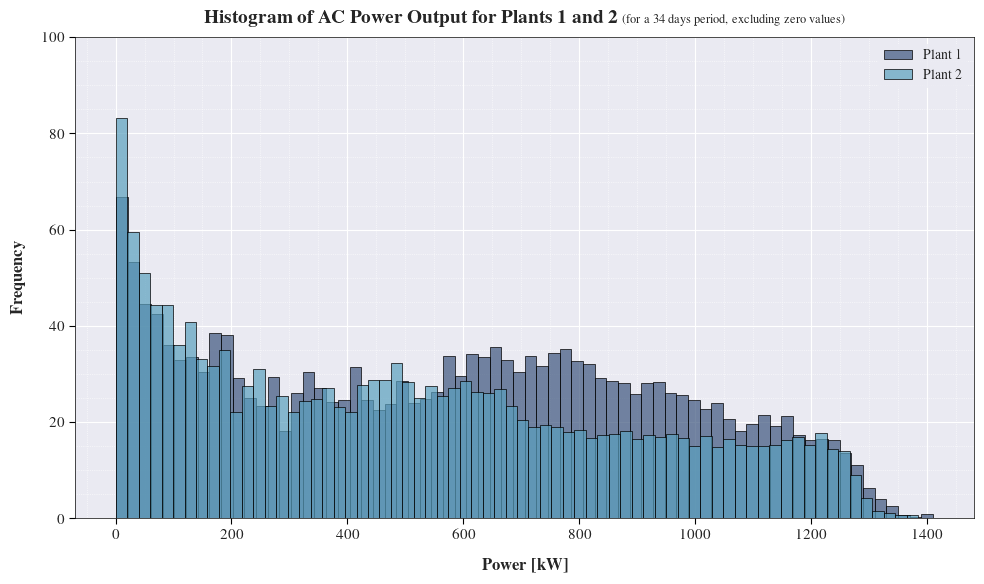

In [273]:
# Histogram of AC Power Output for Plants 1 and 2 (excluding zero values)
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    data=plant1_gen[plant1_gen['AC_POWER'] > 0],
    x="AC_POWER",
    bins=70,
    color=darkblue,
    kde=False,
    stat='frequency',
    label='Plant 1',
    edgecolor='black',
    alpha=0.7,
    linewidth=0.5
)

sns.histplot(
    data=plant2_gen[plant2_gen['AC_POWER'] > 0],
    x="AC_POWER",
    bins=70,
    color=darkcyan,
    kde=False,
    stat='frequency',
    label='Plant 2',
    edgecolor='black',
    alpha=0.7,
    linewidth=0.5
)

# Axis limits
# plt.xlim(left=0, right=1000)
plt.ylim(top=100)

# Axis labels
plt.xlabel(r"\textbf{Power [kW]}", fontsize=12, labelpad=12)
plt.ylabel(r"\textbf{Frequency}", fontsize=12, labelpad=12)
plt.grid(True)

# Plot title
plt.title(r"\textbf{Histogram of AC Power Output for Plants 1 and 2} \small(for a 34 days period, excluding zero values)", fontsize=14, pad=10)

# Legend
handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(handles[::1], labels[::1], fontsize=10, title_fontsize=12) # not reversed
legend.get_frame().set_linewidth(0)  # removes border line

# Axis ticks
plt.minorticks_on()
plt.tick_params(which='major', direction='out', width=0.8, bottom=True, left=True, color='black',size=4)  # black ticks

# Draw box around plot area (axes)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor("black")
    spine.set_linewidth(.5)

# Grid
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, color='white')
plt.grid(True, which='major', linestyle='-', linewidth=0.8, color='white')
plt.tight_layout()

# plt.savefig("/Users/sergimarsol/Documents/UNIVERSITAT/TFG/Thesis/Figures/arrival_delay_histplot.svg", format="svg")
plt.show()


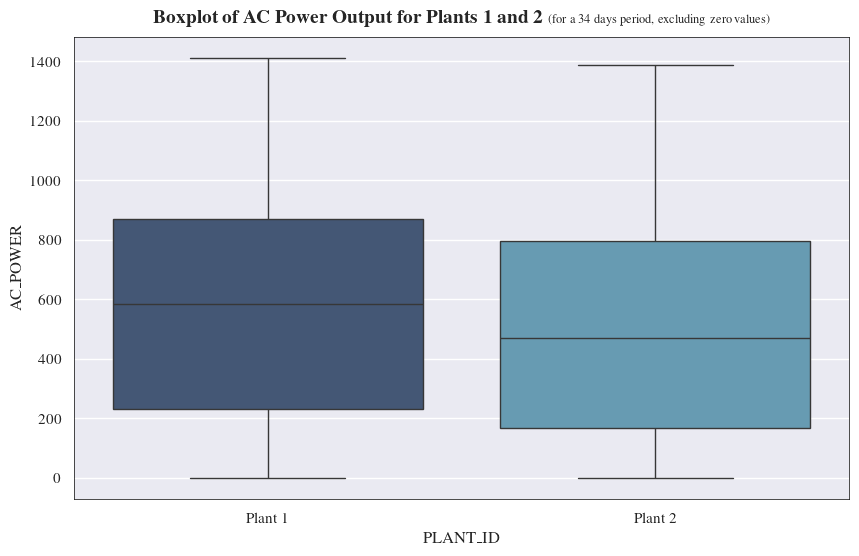

In [252]:
# Boxplot of AC Power for Plants 1 and 2
# --------------------------------------------
plants_gen['PLANT_ID'] = plants_gen['PLANT_ID'].astype('category')

# Custom X-axis labels
unique_plant_ids = [plant1_gen['PLANT_ID'].unique()[0], plant2_gen['PLANT_ID'].unique()[0]]
custom_labels = ['Plant 1', 'Plant 2']

fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(
    x='PLANT_ID',      # X-axis: The categorical variable to group by (the plants)
    y='AC_POWER',      # Y-axis: The continuous variable to plot the distribution of
    data=plants_gen[plants_gen['AC_POWER'] > 0],
    hue = 'PLANT_ID',
    palette=[darkblue, darkcyan],
)

plt.xticks(
    ticks=range(len(unique_plant_ids)), # The positions (0 and 1) where the labels go
    labels=custom_labels,               # The new labels to display ('Plant 1', 'Plant 2')
    fontsize=11
)

# Title
plt.title(r"\textbf{Boxplot of AC Power Output for Plants 1 and 2} \small(for a 34 days period, excluding zero values)", fontsize=14, pad=10)

# Draw box around plot area (axes)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor("black")
    spine.set_linewidth(.5)

# Hide legend
plt.legend().set_visible(False)

plt.show()

##### A.2 Inversor Level AC Power Output Comparison per Plant (2 plots)

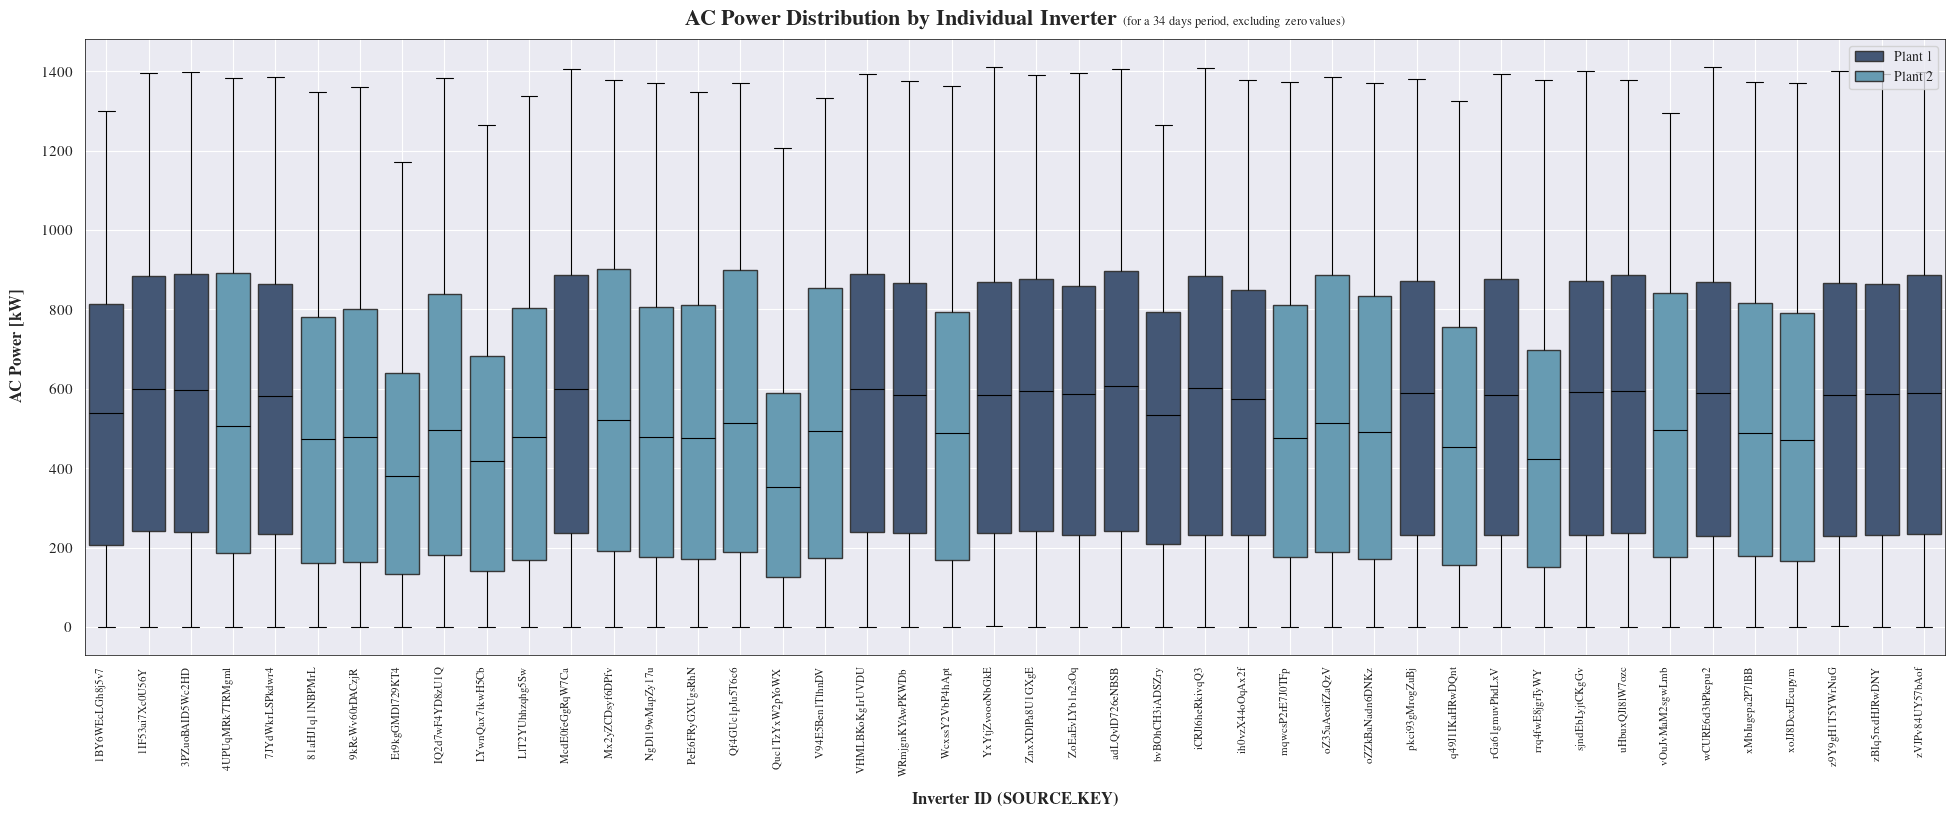

In [295]:
# Boxplot of AC Power per Inverter, colored by Plant ID
# -------------------------------------------------------
plants_gen['PLANT_ID'] = plants_gen['PLANT_ID'].astype('category')
plants_gen['SOURCE_KEY'] = plants_gen['SOURCE_KEY'].astype('category')

# Filter out zero power readings
df_inverter_analysis = plants_gen[plants_gen['AC_POWER'] > 0].copy()

# Identify unique Plant IDs to ensure the color mapping is correct
unique_plant_ids = df_inverter_analysis['PLANT_ID'].unique()

# Create a custom color map to color inverters based on their PLANT_ID
# (Assuming darkblue and darkcyan are defined variables in your environment)
plant_color_map = {
    unique_plant_ids[0]: darkblue,  # Plant 1 color
    unique_plant_ids[1]: darkcyan   # Plant 2 color
}

fig, ax = plt.subplots(figsize=(24, 8)) # Significantly increased size for readability

# --- 1. Create the Box Plot (x=Inverter, hue=Plant for coloring) ---
sns.boxplot(
    x='SOURCE_KEY',     # X-axis: All Inverters combined
    y='AC_POWER',       # Y-axis: AC Power Output
    data=df_inverter_analysis,
    
    # Grouping and Coloring
    hue='PLANT_ID', 
    palette=plant_color_map, 
    dodge=False,        # Disable dodge so boxes for the same inverter don't overlap (since they are unique across plants)

    # Flier/Outlier Styling
    flierprops={
        'marker': 'o',
        'markerfacecolor': 'red',
        'markeredgecolor': 'red',
        'markersize': 4,
        'alpha': 0.6
    }
)

# --- 2. Manually Set Edge Color and Line Width (Fix for older Seaborn versions) ---
# Set the contour color for all boxes to black (linewidth 0.5)
for box in ax.artists:
    box.set_edgecolor('black')
    box.set_linewidth(0.5)

# Set line properties for whiskers and median
for line in ax.lines:
    line.set_color('black')
    line.set_linewidth(0.8)


# --- 3. Readability Adjustments ---

# Rotate X-axis ticks for readability
plt.xticks(
    rotation=90, # Increased rotation
    ha='right',
    fontsize=8
)

# --- 4. Labels and Title ---

plt.title(r"\textbf{AC Power Distribution by Individual Inverter} \small(for a 34 days period, excluding zero values)", fontsize=16, pad=10)
plt.xlabel(r"\textbf{Inverter ID (SOURCE\_KEY)}", fontsize=12, labelpad=12)
plt.ylabel(r"\textbf{AC Power [kW]}", fontsize=12, labelpad=12)

# Grid
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, color='white')
plt.grid(True, which='major', linestyle='-', linewidth=0.8, color='white')

# Draw box around plot area (axes)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor("black")
    spine.set_linewidth(.5)

# Add legend and rename labels to Plant 1 and Plant 2
handles, labels = ax.get_legend_handles_labels()
new_labels = ["Plant 1", "Plant 2"]

plt.legend(handles, new_labels, fontsize=10, title_fontsize=12, loc='upper right')

plt.show()

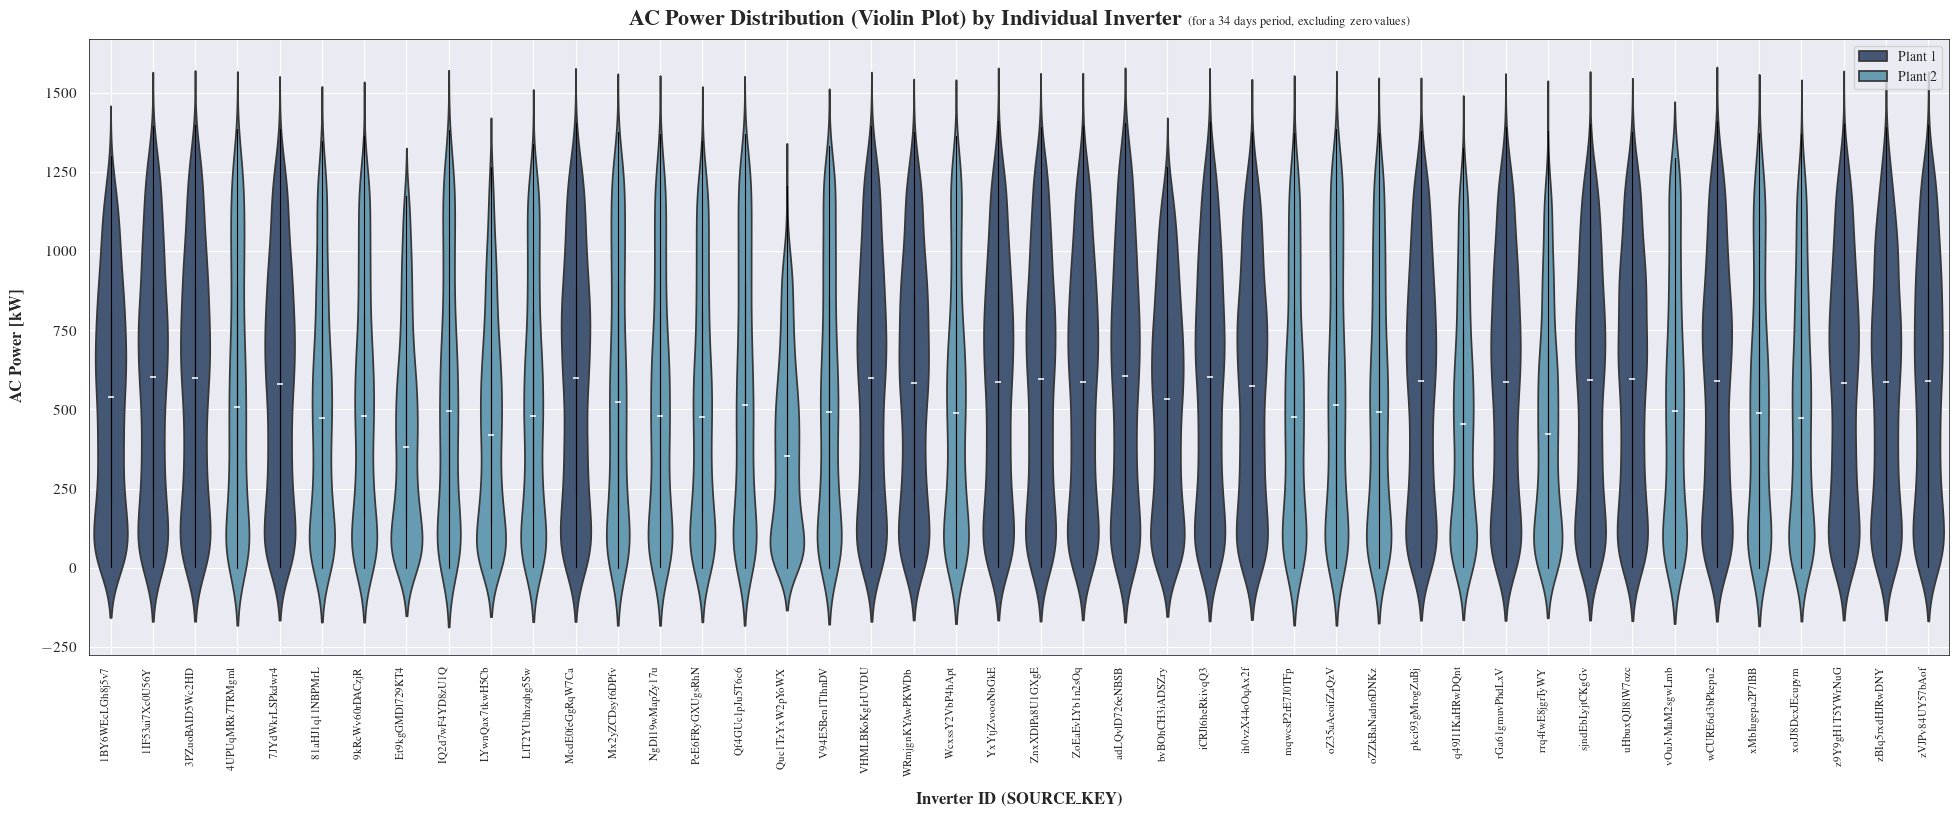

In [357]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections # Needed for type checking if going the collections route, but we stick to artists/lines for compatibility

# Assuming plants_gen, darkblue, and darkcyan are defined in your actual environment
# (The code below assumes their existence and structure as described in your prompt)

# Boxplot of AC Power per Inverter, colored by Plant ID
# -------------------------------------------------------
plants_gen['PLANT_ID'] = plants_gen['PLANT_ID'].astype('category')
plants_gen['SOURCE_KEY'] = plants_gen['SOURCE_KEY'].astype('category')

# Filter out zero power readings
df_inverter_analysis = plants_gen[plants_gen['AC_POWER'] > 0].copy()

# Identify unique Plant IDs to ensure the color mapping is correct
unique_plant_ids = df_inverter_analysis['PLANT_ID'].unique()

# Create a custom color map to color inverters based on their PLANT_ID
# (Assuming darkblue and darkcyan are defined variables in your environment)
plant_color_map = {
    unique_plant_ids[0]: darkblue,  # Plant 1 color
    unique_plant_ids[1]: darkcyan   # Plant 2 color
}

fig, ax = plt.subplots(figsize=(24, 8)) # Significantly increased size for readability

# --- 1. Create the Violin Plot (x=Inverter, hue=Plant for coloring) ---
sns.violinplot(
    x='SOURCE_KEY',      # X-axis: All Inverters combined
    y='AC_POWER',        # Y-axis: AC Power Output
    data=df_inverter_analysis,

    # Grouping and Coloring
    hue='PLANT_ID',
    palette=plant_color_map,
    dodge=False,         # Disable dodge so violins for the same inverter don't overlap (since they are unique across plants)

    # By default, inner='box' will be used, showing a mini boxplot inside the violin
)

# --- 2. Manually Set Edge Color and Line Width ---
# Set the contour color for all violins to black (linewidth 0.5)
for violin in ax.artists:
    violin.set_edgecolor('black')
    violin.set_linewidth(0.5)

# Set line properties for inner lines (e.g., median, quartiles from the inner='box')
for line in ax.lines:
    line.set_color('black')
    line.set_linewidth(0.8)


# --- 3. Readability Adjustments ---

# Rotate X-axis ticks for readability
plt.xticks(
    rotation=90, # Increased rotation
    ha='right',
    fontsize=8
)

# --- 4. Labels and Title ---

# Updated title to reflect the change to Violin Plot
plt.title(r"\textbf{AC Power Distribution (Violin Plot) by Individual Inverter} \small(for a 34 days period, excluding zero values)", fontsize=16, pad=10)
plt.xlabel(r"\textbf{Inverter ID (SOURCE\_KEY)}", fontsize=12, labelpad=12)
plt.ylabel(r"\textbf{AC Power [kW]}", fontsize=12, labelpad=12)

# Grid
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, color='white')
plt.grid(True, which='major', linestyle='-', linewidth=0.8, color='white')

# Draw box around plot area (axes)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor("black")
    spine.set_linewidth(.5)

# Add legend and rename labels to Plant 1 and Plant 2
handles, labels = ax.get_legend_handles_labels()
new_labels = ["Plant 1", "Plant 2"]

plt.legend(handles, new_labels, fontsize=10, title_fontsize=12, loc='upper right')

plt.show()

#### B. Weather Sensor Data Plots

##### B.1 Solar Irradiance Comparison per Plant (2 plots)

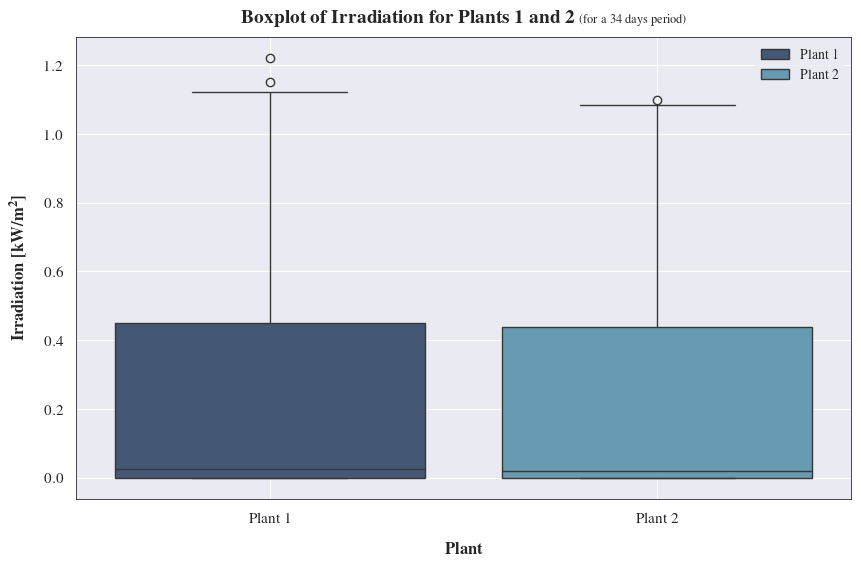

In [340]:
# Boxplot of Irradiation for Plants 1 and 2
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x='PLANT_ID',      # X-axis: The categorical variable to group by (the plants)
    y='IRRADIATION',      # Y-axis: The continuous variable to plot the distribution of
    data=plants_weather,
    hue = 'PLANT_ID',
    palette=[darkblue, darkcyan],
)

plt.xticks(
    ticks=range(len(unique_plant_ids)), # The positions (0 and 1) where the labels go
    labels=custom_labels,               # The new labels to display ('Plant 1', 'Plant 2')
    fontsize=11
)


# Title
plt.title(r"\textbf{Boxplot of Irradiation for Plants 1 and 2} \small(for a 34 days period)", fontsize=14, pad=10)
plt.xlabel(r"\textbf{Plant}", fontsize=12, labelpad=12)
plt.ylabel(r"\textbf{Irradiation [kW/m$^\mathbf{2}$]}", fontsize=12, labelpad=12)

# Grid
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, color='white')
plt.grid(True, which='major', linestyle='-', linewidth=0.8, color='white')

# Draw box around plot area (axes)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor("black")
    spine.set_linewidth(.5)

# Add legend and rename labels to Plant 1 and Plant 2
handles, labels = ax.get_legend_handles_labels()
new_labels = ["Plant 1", "Plant 2"]

legend = plt.legend(handles, new_labels, fontsize=10, title_fontsize=12, loc='upper right')    
legend.get_frame().set_linewidth(0)  # removes border line

plt.show()

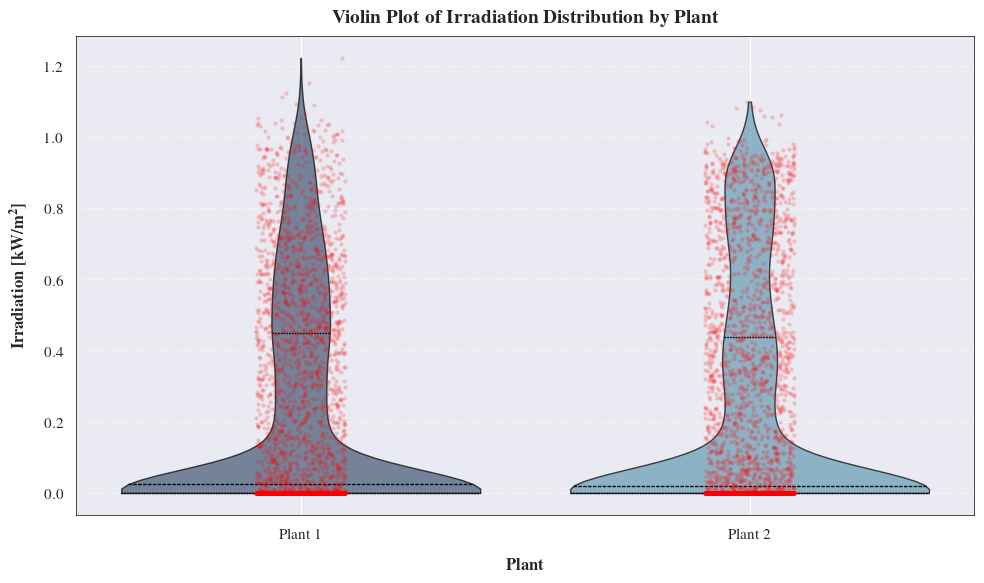

In [341]:
# Violin Plot of Irradiation for Plants 1 and 2
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

sns.violinplot(
    x='PLANT_ID', 
    y='IRRADIATION', 
    data=plants_weather,
    hue = 'PLANT_ID',
    palette=[darkblue, darkcyan],
    inner='quartile',  # Show median and quartiles inside the violin
    cut=0,             # Prevent violin extending beyond min/max data
    linewidth=1.0,     # Edge width
    edgecolor='black', 
    alpha=0.7,
    ax=ax,
)

# --- 2. Add Stripplot for Outliers/Individual Points ---
sns.stripplot(
    x='PLANT_ID',
    y='IRRADIATION',
    data=plants_weather,
    color='red',      # Use a distinct color (red) to highlight the points
    size=3,           # Small marker size
    alpha=0.2,        # Transparency
    ax=ax
)

# --- 3. X-axis Tick Renaming ---
plt.xticks(
    ticks=range(len(unique_plant_ids)), 
    labels=custom_labels, 
    fontsize=11
)

# --- 4. Labels and Title ---
plt.title(r"\textbf{Violin Plot of Irradiation Distribution by Plant}", fontsize=14, pad=10)
plt.xlabel(r"\textbf{Plant}", fontsize=12, labelpad=12)
plt.ylabel(r"\textbf{Irradiation [kW/m$^\mathbf{2}$]}", fontsize=12, labelpad=12)

# Grid
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, color='white')
plt.grid(True, which='major', linestyle='-', linewidth=0.8, color='white')

# Draw box around plot area (axes)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor("black")
    spine.set_linewidth(.5)

# Turn legend off
plt.legend().set_visible(False)

# --- 6. Finalization ---
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### B.2 Temperature Comparison per Plant (2 plots)

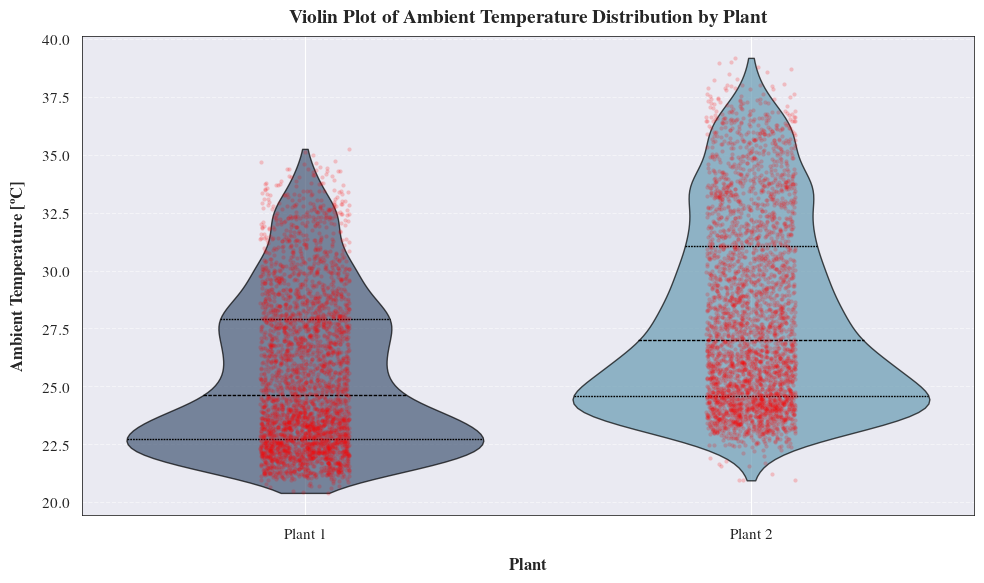

In [355]:
# Violin Plot of Ambient Temperature for Plants 1 and 2
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

sns.violinplot(
    x='PLANT_ID', 
    y='AMBIENT_TEMPERATURE', 
    data=plants_weather,
    hue = 'PLANT_ID',
    palette=[darkblue, darkcyan],
    inner='quartile',  # Show median and quartiles inside the violin
    cut=0,             # Prevent violin extending beyond min/max data
    linewidth=1.0,     # Edge width
    edgecolor='black', 
    alpha=0.7,
    ax=ax,
)

# --- 2. Add Stripplot for Outliers/Individual Points ---
sns.stripplot(
    x='PLANT_ID',
    y='AMBIENT_TEMPERATURE',
    data=plants_weather,
    color='red',      # Use a distinct color (red) to highlight the points
    size=3,           # Small marker size
    alpha=0.2,        # Transparency
    ax=ax
)

# --- 3. X-axis Tick Renaming ---
plt.xticks(
    ticks=range(len(unique_plant_ids)), 
    labels=custom_labels, 
    fontsize=11
)

# --- 4. Labels and Title ---
plt.title(r"\textbf{Violin Plot of Ambient Temperature Distribution by Plant}", fontsize=14, pad=10)
plt.xlabel(r"\textbf{Plant}", fontsize=12, labelpad=12)
plt.ylabel(r"\textbf{Ambient Temperature [ºC]}", fontsize=12, labelpad=12)

# Grid
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, color='white')
plt.grid(True, which='major', linestyle='-', linewidth=0.8, color='white')

# Draw box around plot area (axes)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor("black")
    spine.set_linewidth(.5)

# Turn legend off
plt.legend().set_visible(False)

# --- 6. Finalization ---
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

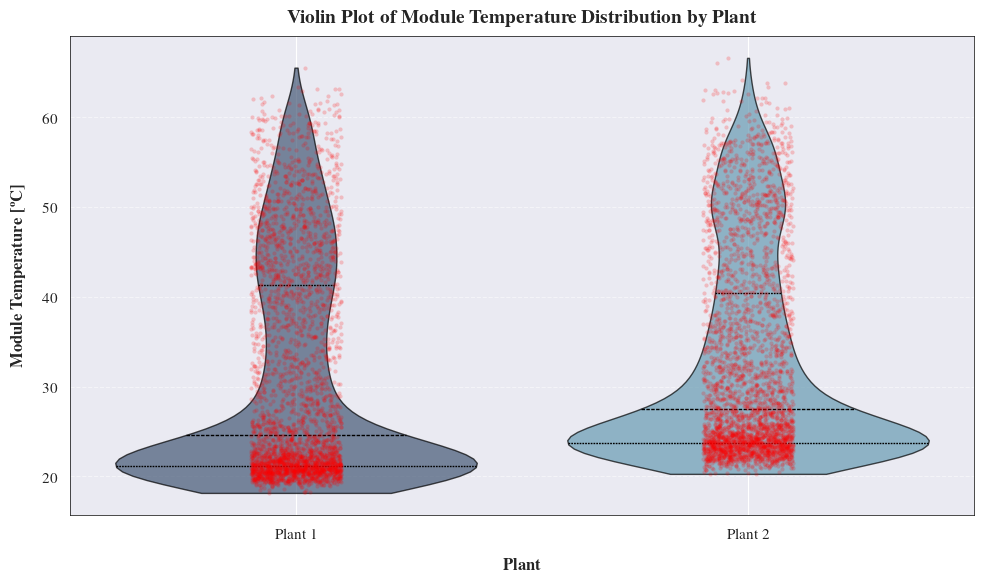

In [356]:
# Violin Plot of Module Temperature for Plants 1 and 2
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

sns.violinplot(
    x='PLANT_ID', 
    y='MODULE_TEMPERATURE', 
    data=plants_weather,
    hue = 'PLANT_ID',
    palette=[darkblue, darkcyan],
    inner='quartile',  # Show median and quartiles inside the violin
    cut=0,             # Prevent violin extending beyond min/max data
    linewidth=1.0,     # Edge width
    edgecolor='black', 
    alpha=0.7,
    ax=ax,
)

# --- 2. Add Stripplot for Outliers/Individual Points ---
sns.stripplot(
    x='PLANT_ID',
    y='MODULE_TEMPERATURE',
    data=plants_weather,
    color='red',      # Use a distinct color (red) to highlight the points
    size=3,           # Small marker size
    alpha=0.2,        # Transparency
    ax=ax
)

# --- 3. X-axis Tick Renaming ---
plt.xticks(
    ticks=range(len(unique_plant_ids)), 
    labels=custom_labels, 
    fontsize=11
)

# --- 4. Labels and Title ---
plt.title(r"\textbf{Violin Plot of Module Temperature Distribution by Plant}", fontsize=14, pad=10)
plt.xlabel(r"\textbf{Plant}", fontsize=12, labelpad=12)
plt.ylabel(r"\textbf{Module Temperature [ºC]}", fontsize=12, labelpad=12)

# Grid
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, color='white')
plt.grid(True, which='major', linestyle='-', linewidth=0.8, color='white')

# Draw box around plot area (axes)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor("black")
    spine.set_linewidth(.5)

# Turn legend off
plt.legend().set_visible(False)

# --- 6. Finalization ---
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### C. Power Generation vs Weather Sensor Data

##### C.1 Power Generation vs Irradiance

(Scatter Plot)

### 2.3.3 Trend Analysis

### 2.3.4 Correlation Analysis

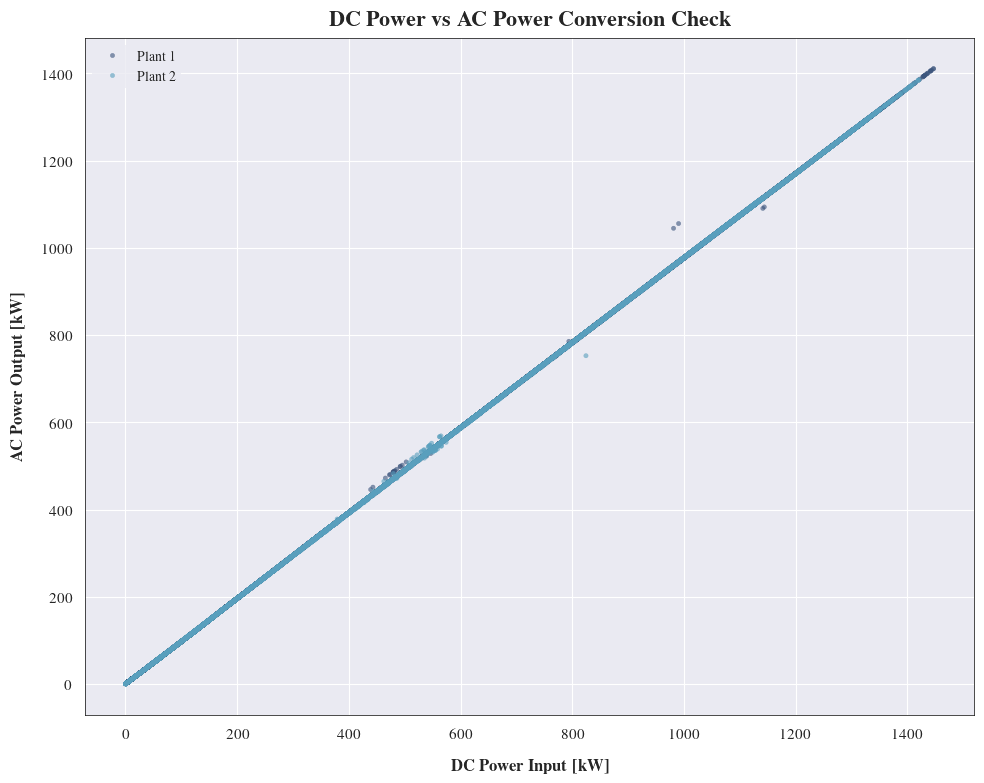

In [272]:
# Scatter Plot: DC Power vs AC Power Conversion Check
# -------------------------------------------------------

# --- 0. Data Setup and Filtering ---

# Filter data to include only generating periods for clearer visualization of the relationship
df_conversion_check = plants_gen[plants_gen['DC_POWER'] > 0].copy()

# Identify unique Plant IDs for coloring
unique_plant_ids = df_conversion_check['PLANT_ID'].unique()
plant_color_map = {
    unique_plant_ids[0]: darkblue,  # Color for Plant 1
    unique_plant_ids[1]: darkcyan   # Color for Plant 2
}

fig, ax = plt.subplots(figsize=(10, 8))

# --- 1. Create the Scatter Plot ---
sns.scatterplot(
    x='DC_POWER',
    y='AC_POWER',
    data=df_conversion_check,
    
    # Use Plant ID for color grouping
    hue='PLANT_ID', 
    palette=plant_color_map,
    
    # Styling for points
    s=10,        # Size of the points
    alpha=0.6,   # Transparency for better density visualization
    edgecolor=None # Remove point outlines
)

# --- 2. Labels and Title ---
plt.title(r"\textbf{DC Power vs AC Power Conversion Check}", fontsize=16, pad=10)
plt.xlabel(r"\textbf{DC Power Input [kW]}", fontsize=12, labelpad=12)
plt.ylabel(r"\textbf{AC Power Output [kW]}", fontsize=12, labelpad=12)

# Grid
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, color='white')
plt.grid(True, which='major', linestyle='-', linewidth=0.8, color='white')
plt.tight_layout()

# Draw box around plot area (axes)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor("black")
    spine.set_linewidth(.5)


# --- 3. Custom Legend ---
# Add legend and rename labels to Plant 1 and Plant 2
handles, labels = ax.get_legend_handles_labels()
new_labels = ["Plant 1", "Plant 2"]


legend = plt.legend(handles, new_labels, fontsize=10, loc='best')
legend.get_frame().set_linewidth(0)  # removes border line


# plt.tight_layout()
plt.show()

### 2.3.5 Pattern Identification

## 2.4 Feature Engineering

### 2.4.1 Feature Scaling

### 2.4.2 Feature Selection